## Baro Array - Animation

### Importing

In [1]:
import os
import gc
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees
from obspy import Stream

from andbro__querrySeismoData import __querrySeismoData

In [2]:
from functions.read_DEM import __read_DEM

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
# import elevation

# !eio clip -o ROMY_30m_DEM.tif --bounds 11.2 48.1 11.3 48.2

In [5]:
dem = __read_DEM("ROMY_30m_DEM.tif")

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [6]:
# plt.contourf(dem['utm_e'],
#              dem['utm_n'],
#              dem['data'],
#              cmap="viridis",
#              levels=list(range(0, 800, 10))
#              )

### Setting Variables

In [7]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

# test 0
# config['tbeg'] = obspy.UTCDateTime("2024-03-16 13:00")
# config['tend'] = obspy.UTCDateTime("2024-03-16 14:00")

# test 1
config['tbeg'] = obspy.UTCDateTime("2024-03-23 10:00")
config['tend'] = obspy.UTCDateTime("2024-03-23 15:00")

# test 2
config['tbeg'] = obspy.UTCDateTime("2024-03-23 04:00")
config['tend'] = obspy.UTCDateTime("2024-03-23 20:00")

# specify stations
config['seeds'] = [
                   'BW.GELB..LDO',
                   'BW.GRMB..LDO',
                   'BW.ALFT..LDO',
                   'BW.BIB..LDO',
                   'BW.TON..LDO',
                   'BW.ROMY..LDI',
]

config['fmin'] = 0.1e-3
config['fmax'] = 1e-3

config['path_to_figs'] = data_path+"/romy_baro/figures/"

config['ref_station'] = 'BW.ROMY..HH*'

config['client'] = RoutingClient("eida-routing")

### Defining Methods

In [8]:
def __get_array_stations(seeds, tbeg, tend):

    route =  RoutingClient("eida-routing")

    for _i, seed in enumerate(seeds):

        net, sta, loc, cha = seed.split(".")


        inv =route.get_stations(
                                network=net,
                                station=sta,
                                channel="*",
                                starttime=tbeg,
                                endtime=tend,
                                # latitude=ref_coords[0],
                                # longitude=ref_coords[1],
                                # minradius=0,
                                # maxradius=max_radius,
                            )
        if _i == 0:
            invs = inv
        else:
            invs += inv

    # inv_check.plot(projection="local");

    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(invs):
        for i, station in enumerate(network):

            codes.append(f'{invs[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)

    # create dataframe
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev': elev})

    # sort the dataframe
    frame.sort_values(by="codes", inplace=True)

    frame.reset_index(inplace=True, drop=True)

    return frame

In [9]:
array_stations = __get_array_stations(config['seeds'], config['tbeg'], config['tend'])

In [10]:
array_stations

,codes,lon,lat,elev
0,BW.ALFT,11.279500,48.142334,0.593
1,BW.BIB,11.247300,48.152200,0.599
2,BW.GELB,11.251400,48.162900,0.628
3,BW.GRMB,11.263500,48.140600,0.656
4,BW.ROMY,11.275476,48.162941,0.571
5,BW.TON,11.288809,48.173897,0.564


In [11]:
def __array_latlon_to_xyz(array_stations, ref_station="GR.FUR"):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """

    from numpy import zeros
    import utm

    # modify ref_station
    net, sta, loc, cha = ref_station.split(".")
    ref_station = f"{net}.{sta}"

    if ref_station not in list(array_stations.codes):
        print(f"-> {ref_station} not vaild")
        return


    for _i in ["x_m", "y_m", "z_m", "utm_n", "utm_e", "utm_zone", "utm_letter"]:
        array_stations[_i] = zeros(array_stations.shape[0])

    sta_ref = array_stations[array_stations.codes == ref_station]
    utm_ref_e, utm_ref_n, utm_zone, utm_letter = utm.from_latlon(sta_ref.lat.iloc[0], sta_ref.lon.iloc[0])
    z_ref = sta_ref.elev.iloc[0]

    for i, sta in array_stations.iterrows():

        utm_e, utm_n, utm_zone, utm_letter = utm.from_latlon(sta.lat, sta.lon)

        array_stations.loc[i, "utm_n"] = utm_n
        array_stations.loc[i, "utm_e"] = utm_e
        array_stations.loc[i, "x_m"] = round(( utm_e - utm_ref_e ), 2)
        array_stations.loc[i, "y_m"] = round(( utm_n - utm_ref_n ), 2)
        array_stations.loc[i, "z_m"] = ( array_stations.loc[i, "elev"] - z_ref ) * 1e3

        array_stations.loc[i, "utm_zone"] = utm_zone
        array_stations.loc[i, "utm_letter"] = str(utm_letter)

    array_stations["x_km"] = array_stations["x_m"] / 1000
    array_stations["y_km"] = array_stations["y_m"] / 1000
    array_stations["z_km"] = array_stations["z_m"] / 1000

    return array_stations

In [12]:
array_stations = __array_latlon_to_xyz(array_stations, ref_station=config['ref_station'])

/tmp/ipykernel_2313932/2256126714.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  array_stations.loc[i, "utm_letter"] = str(utm_letter)


In [13]:
array_stations

,codes,lon,lat,elev,x_m,y_m,z_m,utm_n,utm_e,utm_zone,utm_letter,x_km,y_km,z_km
0,BW.ALFT,11.279500,48.142334,0.593,367.11,-2281.38,22.0,5.334633e+06,669567.346291,32.0,U,0.36711,-2.28138,0.022
1,BW.BIB,11.247300,48.152200,0.599,-2060.10,-1255.39,28.0,5.335659e+06,667140.137071,32.0,U,-2.06010,-1.25539,0.028
2,BW.GELB,11.251400,48.162900,0.628,-1790.01,-57.27,57.0,5.336857e+06,667410.222437,32.0,U,-1.79001,-0.05727,0.057
3,BW.GRMB,11.263500,48.140600,0.656,-817.36,-2509.26,85.0,5.334405e+06,668382.879818,32.0,U,-0.81736,-2.50926,0.085
4,BW.ROMY,11.275476,48.162941,0.571,0.00,0.00,0.0,5.336915e+06,669200.235012,32.0,U,0.00000,0.00000,0.000
5,BW.TON,11.288809,48.173897,0.564,955.10,1247.08,-7.0,5.338162e+06,670155.332442,32.0,U,0.95510,1.24708,-0.007


In [14]:
def __calculate_distance_of_stations(array_stations, output="km", ref_station=None):
    '''
    from obspy.geodetics import locations2degrees

    '''

    from numpy import round

    N = len(array_stations)

    # modify ref_station
    if ref_station is not None:
        net, sta, loc, cha = ref_station.split(".")
        ref_station = f"{net}.{sta}"

    if ref_station is not None:
        dist_in_deg = {}
        station1 = array_stations[array_stations.codes == ref_station]
        lat1, lon1 = station1.lat, station1.lon
        for j, station2 in array_stations.iterrows():
            name = str(station2.codes)
            _dist= locations2degrees(lat1  = lat1,
                                      long1 = lon1,
                                      lat2  = station2[2],
                                      long2 = station2[1],
                                      )
            if output == "km":
                dist_in_deg[name] = round(_dist[0]*111, decimals=2)
            elif output == "deg":
                dist_in_deg[name] = round(_dist[0], decimals=2)

    else:
        dist_in_deg = np.zeros((N, N))
        for i, station1 in array_stations.iterrows():
            for j, station2 in array_stations.iterrows():
                 _dist = locations2degrees(lat1  = station1[2],
                                          long1 = station1[1],
                                          lat2  = station2[2],
                                          long2 = station2[1],
                                          )
            if output == "km":
                dist_in_deg[i][j] = round(_dist*111, decimals=4)
            elif output == "deg":
                dist_in_deg[i][j] = round(_dist, decimals=4)

    return dist_in_deg

In [15]:
from functions.calculate_distance_of_stations import __calculate_distance_of_stations

## Compute station distance

In [16]:
distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=config['ref_station'])
distances

{'BW.ALFT': 2.31,
 'BW.BIB': 2.41,
 'BW.GELB': 1.79,
 'BW.GRMB': 2.64,
 'BW.ROMY': 0.0,
 'BW.TON': 1.57}

In [17]:
cross_distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=None)
cross_distances

array([[0.  , 2.64, 3.1 , 1.21, 2.31, 3.58],
       [2.64, 0.  , 1.23, 1.77, 2.41, 3.92],
       [3.1 , 1.23, 0.  , 2.64, 1.79, 3.04],
       [1.21, 1.77, 2.64, 0.  , 2.64, 4.15],
       [2.31, 2.41, 1.79, 2.64, 0.  , 1.57],
       [3.58, 3.92, 3.04, 4.15, 1.57, 0.  ]])

### Calulcate Distances, Plot Array Geometry and Response

In [18]:
def __plot_array_geometry_and_response(array, transff, klim, kstep, names=None, unit=None, lblxy=[]):

    import numpy as np

    # calulcate geometrical center of array
    array_center = [np.median(array[:, 0]), np.median(array[:, 1])]

    # find geometrical limits of array
    lon_min, lon_max = np.min(array[:, 0]), np.max(array[:, 0])
    lat_min, lat_max = np.min(array[:, 1]), np.max(array[:, 1])

    # define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim

    # _________________________________________________________

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    fs = 12

    if unit == "km":
        xdata = (array[:, 0]-array_center[0])*111.
        ydata = (array[:, 1]-array_center[1])*111. * np.cos(array[:, 1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)

    elif unit == "deg":
        xdata = array[:, 0]
        ydata = array[:, 1]
        x0, y0 = array_center[0], array_center[1]

    # plot digital elevation model
    # axes[0].contourf(dem['longitude'],
    #                  dem['latitude'],
    #                  dem['data'],
    #                  cmap="gray",
    #                  levels=list(range(400, 650, 2)),
    #                  )

    cm = axes[0].pcolormesh(dem['longitude'],
                            dem['latitude'],
                            dem['data'],
                            cmap="gray",
                            shading='gouraud',
                            )

    cax = axes[0].inset_axes([0.1, 0.92, 0.2, 0.05])
    cb = plt.colorbar(cm, ax=axes[0], cax=cax, orientation="horizontal")
    cb.set_label("Elevation (m)", fontsize=fs, color="w")
    cb.ax.set_xticklabels(cb.ax.xaxis.get_ticklabels(), color="w")
    cb.ax.xaxis.set_tick_params(color="w")
    cb.outline.set_edgecolor("w")

    # ________________________________________________
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata))*0.99, max(abs(ydata))*1.01])
        axes[0].set_xlim([-max(abs(xdata))*0.99, max(abs(xdata))*1.01])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

        axes[0].set_ylim([min(abs(ydata))*0.9999, max(abs(ydata))*1.0001])
        axes[0].set_xlim([min(abs(xdata))*0.999, max(abs(xdata))*1.001])

    axes[0].set_title('ROMY Array Stations', fontsize=fs+2)

    if len(lblxy) > 0:
        for _i, (x, y, s) in enumerate(zip(xdata, ydata, list(names))):
            dx, dy = lblxy[_i]
            axes[0].text(x+dx, y+dy, s, ha="left", va="top")
    else:
        for x, y, s in zip(xdata, ydata, list(names)):
            axes[0].text(x+.001, y+.0, s, ha="left", va="top")

    # ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
                         np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
                         transff.T, cmap=obspy_sequential,
                        )

    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('Array Response Function', fontsize=fs+2)

    for _k, ll in enumerate(['(a)','(b)']):
        axes[_k].text(0.006, 0.99, ll, ha="left", va="top", transform=axes[_k].transAxes, fontsize=fs+1, color="w")

    plt.show();
    return fig

In [19]:
# get maximal distance
# dist_max = max(distances.values())
dist_max = max(cross_distances.reshape(cross_distances.size, 1))[0]

lambda_min = 1*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )

/tmp/ipykernel_2313932/1758119914.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_xticklabels(cb.ax.xaxis.get_ticklabels(), color="w")


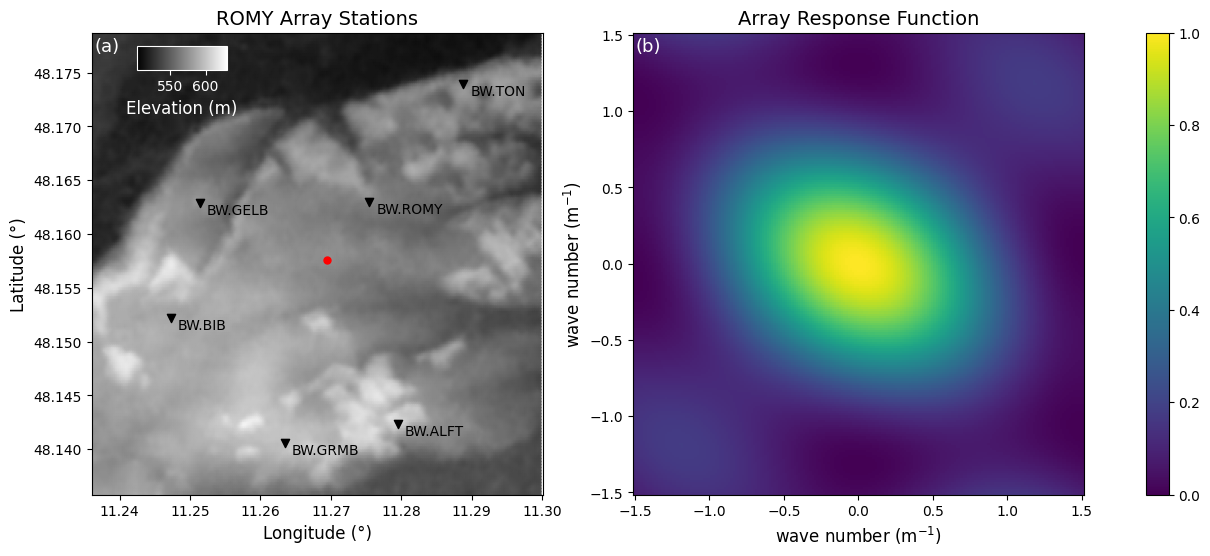

In [20]:
fig = __plot_array_geometry_and_response(coordinates,
                                         transff,
                                         config['k_max'],
                                         config['k_step'],
                                         array_stations.codes,
                                         unit="deg",
                                        )

fig.savefig(config['path_to_figs']+"RomyBaro_array_response.png", format="png", dpi=150, bbox_inches='tight')

In [21]:
for i, array_station in array_stations.iterrows():

    # adjustment for ROMY pressure
    if "ROMY" in array_station.codes:
        array_stations.codes.iloc[i] = "BW.PROMY"


/tmp/ipykernel_2313932/2492493264.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  array_stations.codes.iloc[i] = "BW.PROMY"


### Load FURT Data

In [22]:
from andbro__load_FURT_stream import __load_furt_stream

In [23]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

### Load Pressure Data

In [24]:
from andbro__read_sds import __read_sds

In [25]:
from functions.interpolate_nan import __interpolate_nan

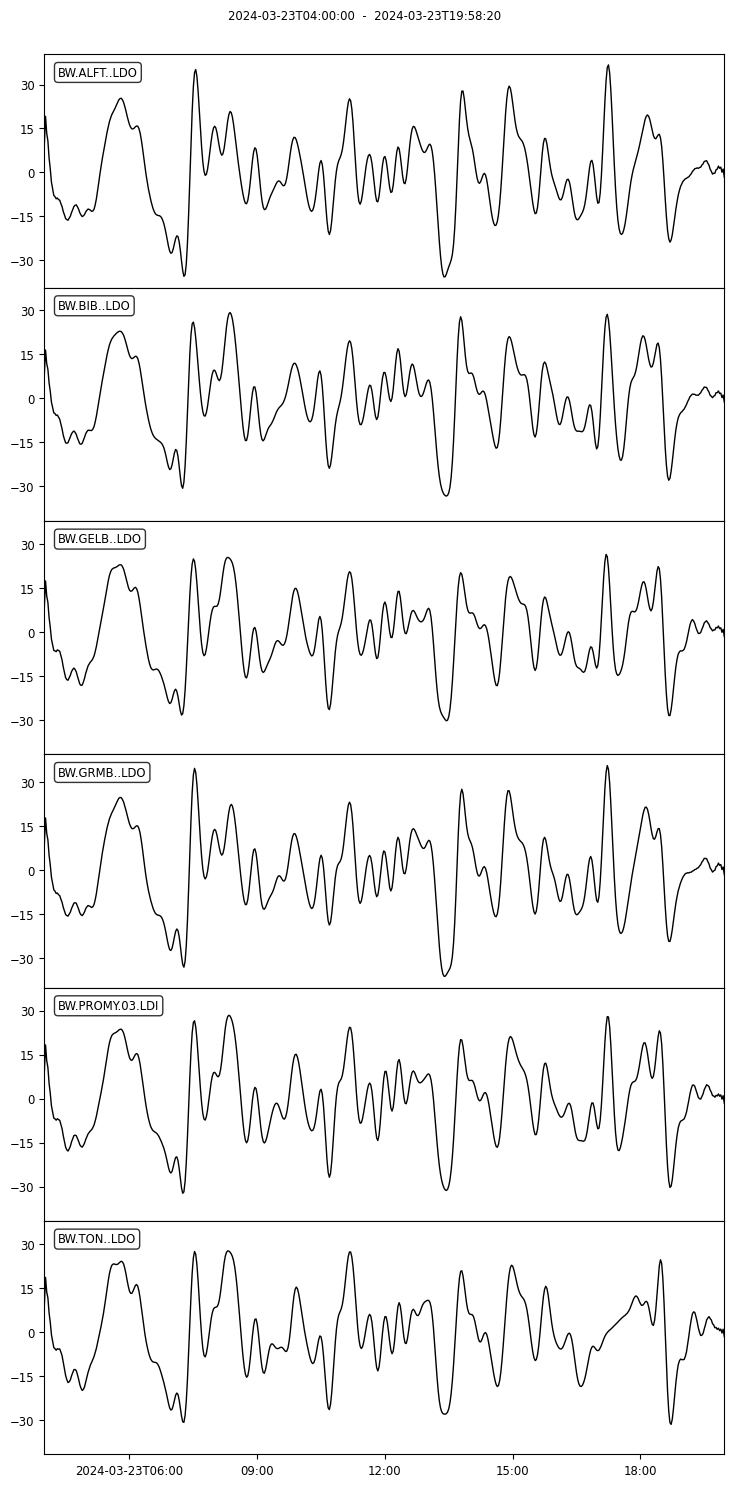

In [26]:
df_pressure = pd.DataFrame()

st = Stream()

for _i, seed in enumerate(config['seeds']):

    if "ROMY" in seed:
        seed = "BW.PROMY.03.LDI"

    ps = __read_sds(archive_path+"temp_archive/", seed, config['tbeg'], config['tend'])

    # convert from Pa to hPa
    if "ROMY" in seed:
        ps[0].data = ps[0].data / 100

    # interpolate nan values
    for tr in ps:
        tr.data = __interpolate_nan(tr.data)

    ps = ps.detrend("simple")

    ps = ps.taper(0.01, type="cosine")

    ps = ps.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ps = ps.resample(config['fmax']*10)

    # convert from hPa to Pa
    ps[0].data = ps[0].data * 100

    if _i == 0:
        df_pressure["time"] = ps[0].times(reftime=config['tbeg'])

    df_pressure[f"{seed.split('.')[0]}.{seed.split('.')[1]}"] = ps[0].data

    st += ps

st.plot();

### Load Pressure Gradient

In [27]:
from functions.compute_baro_gradient_romy import __compute_baro_gradient_romy
from functions.get_angle import __get_angle

In [28]:
# def get_angle(N, E, out="deg"):
#     ang = np.zeros(len(E))
#     for i, (n, e) in enumerate(zip(N, E)):
#         # Q2
#         if n >= 0 and e < 0:
#             ang[i] = np.rad2deg(np.arctan(n/e)) + 180
#         # Q3
#         elif n < 0 and e < 0:
#             ang[i] = np.rad2deg(np.arctan(n/e)) + 180
#         # Q4
#         elif n < 0 and e >= 0:
#             ang[i] = np.rad2deg(np.arctan(n/e)) + 360
#         # Q1
#         else:
#             ang[i] = np.rad2deg(np.arctan(n/e))
#     if out == "deg":
#         return ang
#     elif out == "rad":
#         return np.deg2rad(ang)

In [29]:
bgrad0 = __compute_baro_gradient_romy(config['tbeg'],
                                     config['tend'],
                                     status=False,
                                     excluded_stations=[],
                                     verbose=False
                                    )

bgrad0 = bgrad0.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)


bgrad = bgrad0.copy()

bgrad = bgrad.resample(config['fmax']*10)


 -> NaN found
 -> bandpass: 0.0001 - 0.01 Hz
 -> continue computing ADR for 6 of 6 stations ...

 -> Runtime: 0.21 minutes



In [30]:
NN = bgrad0.select(channel="*N")[0].data
EE = bgrad0.select(channel="*E")[0].data

tt = bgrad0.select(channel="*N")[0].times()

bgrad_ang = __get_angle(NN, EE, out="deg")
bgrad_abs = np.sqrt(NN**2 + EE**2)

# bgrad_ang = np.array([x + 360 if x < 180 else x for x in bgrad_ang])
bgrad_ang = ((bgrad_ang + 90) % 360) - 180

### Plot Animation

In [31]:
def __gradient_grid(frame):

    from scipy.interpolate import griddata

    dx, dy = 0.250, 0.250

    xx, yy = array_stations.x_km, array_stations.y_km

    grid_x, grid_y = np.mgrid[min(xx)*1.2:max(xx)*1.2:dx, min(yy)*1.2:max(yy)*1.2:dy]

    points, values = [], []
    for i, sta in enumerate(df_pressure.keys()):
        if sta == "time":
            continue

        _x = array_stations[array_stations.codes == sta].x_km.iloc[0]
        _y = array_stations[array_stations.codes == sta].y_km.iloc[0]

        points.append([_x, _y])
        values.append(df_pressure[sta].iloc[frame])

    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

    return grid_x, grid_y, grid_z

-> launch animation
0 ...
10 ...
20 ...
30 ...
40 ...
50 ...
60 ...
70 ...
80 ...
90 ...
100 ...
110 ...
120 ...
130 ...
140 ...
150 ...
160 ...
170 ...
180 ...
190 ...
200 ...
210 ...
220 ...
230 ...
240 ...
250 ...
260 ...
270 ...
280 ...
290 ...
300 ...
310 ...
320 ...
330 ...
340 ...
350 ...
360 ...
370 ...
380 ...
390 ...
400 ...
410 ...
420 ...
430 ...
440 ...
450 ...
460 ...
470 ...
480 ...
490 ...
500 ...
510 ...
520 ...
530 ...
540 ...
550 ...
560 ...
570 ...
-> stored video: romy_barometer_test.mp4


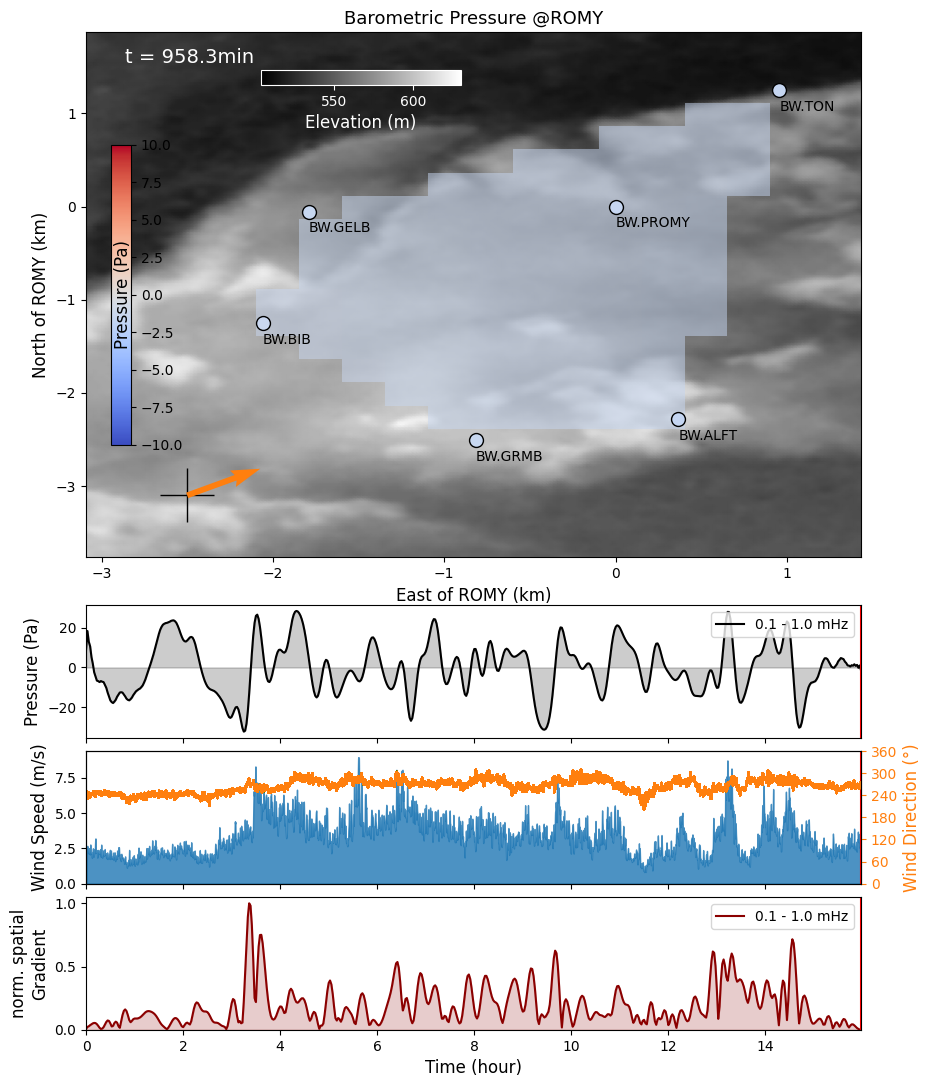

In [32]:
def __makeplot_barometer_array():

    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.gridspec import GridSpec
    from functions.smoothing import __smooth
    from functions.interpolate_nan import __interpolate_nan

    ref_station = "BW.PROMY"

    wdir = __smooth(__interpolate_nan(furt.select(channel="LAD")[0].data), 60)
    wvel = __smooth(__interpolate_nan(furt.select(channel="LAW")[0].data), 60)
    wdir = __interpolate_nan(furt.select(channel="LAD")[0].data)
    wvel = __interpolate_nan(furt.select(channel="LAW")[0].data)

    frames = df_pressure.shape[0]
    # frames = 10

    Ncol, Nrow = 1, 8

    maker_size = 100

    p_min, p_max = -10, 10

    time_scaling = 1/3600

    tmin, tmax = min(df_pressure["time"]*time_scaling), max(df_pressure["time"]*time_scaling)

    font = 12

    fig = plt.figure(figsize=(10, 15))

    # set tight layout
    fig.set_tight_layout(True)

    # adjust space between subplots
    plt.subplots_adjust(hspace=0.3)

    # specify grid of subplots
    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=2.0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs1[1:5, :])
    ax2 = fig.add_subplot(gs2[5, :])
    ax3 = fig.add_subplot(gs2[6, :])
    ax4 = fig.add_subplot(gs2[7, :])

    ax3_1 = ax3.twinx()

    # define first colorbar axis
    cax1 = fig.add_axes([0.15, 0.5, 0.02, 0.2]) #[left, bottom, width, height]

    # define second colorbar axis
    cax2 = fig.add_axes([0.3, 0.74, 0.2, 0.01]) #[left, bottom, width, height]

    # _____________________________________
    # ax1.scatter(array_stations.x_m, array_stations.y_m, s=maker_size, edgecolor="k", color="w")

    cmap = plt.get_cmap("coolwarm")

    def init():

        print(f"-> launch animation")


    def update(i):

        if i%10 == 0:
            print(f"{i} ...")

        gx, gy, gz = __gradient_grid(i)

        # _______________________________________________________

        # clear the axis each frame
        ax1.clear()
        # cax1.clear()
        cax2.clear()

        ax1.set_xlabel("East of ROMY (km)", fontsize=font)
        ax1.set_ylabel("North of ROMY (km)", fontsize=font)
        ax1.set_title("Barometric Pressure @ROMY", fontsize=font+1)

        # add topography
        # cm = ax1.contourf((dem['utm_e'] - array_stations[array_stations.codes == ref_station].utm_e.iloc[0] ) / 1000,
        #                   (dem['utm_n'] - array_stations[array_stations.codes == ref_station].utm_n.iloc[0] ) / 1000,
        #                   dem['data'],
        #                   cmap="gray",
        #                   levels=np.arange(500, 700, 10),
                          # levels=list(range(500, 700, 2)),
                          # rasterized=True,
                         # )
        cm = ax1.pcolormesh((dem['utm_e'] - array_stations[array_stations.codes == ref_station].utm_e.iloc[0] ) / 1000,
                            (dem['utm_n'] - array_stations[array_stations.codes == ref_station].utm_n.iloc[0] ) / 1000,
                            dem['data'],
                            cmap="gray",
                            shading='gouraud',
                            )

        cb = plt.colorbar(cm, ax=ax1, cax=cax2, orientation="horizontal")
        cb.set_label("Elevation (m)", fontsize=font, color="w")
        cb.ax.set_xticklabels(cb.ax.xaxis.get_ticklabels(), color="w")
        cb.ax.xaxis.set_tick_params(color="w")
        cb.outline.set_edgecolor("w")

        # add interpolated gradient
        gg = ax1.pcolormesh(gx, gy, gz, alpha=0.5, cmap=cmap, vmin=p_min, vmax=p_max)

        # add gradient vector
        romy_x = array_stations[array_stations.codes == "BW.PROMY"].x_km
        romy_y = array_stations[array_stations.codes == "BW.PROMY"].y_km

        # select components (reverse is intended for tilt instead of rotation!)
        E = -1*bgrad.select(channel="*N")[0].data
        N = -1*bgrad.select(channel="*E")[0].data
        ax1.quiver(romy_x, romy_y, E[i]*5e4, N[i]*5e4, color='darkred', units='xy', scale=1)

        # add wind (reverse and shift 90°)
        _wdir = ((abs(wdir[i] - 360) + 90 ) % 360)
        _wdir = ((_wdir - 180) + 360 ) %360
        _x = wvel[i] * np.cos(np.deg2rad(_wdir))
        _y = wvel[i] * np.sin(np.deg2rad(_wdir))
        ax1.scatter(-2.5, -3.1, s=1500, marker="+", color="k", lw=1)
        ax1.quiver(-2.5, -3.1, _x/5, _y/5, color='tab:orange', units='xy', scale=0.5)

        # replot data
        for station in df_pressure.keys():
            if "time" in station:
                continue

            im = ax1.scatter(array_stations[array_stations.codes == station].x_km,
                             array_stations[array_stations.codes == station].y_km,
                             s=maker_size,
                             c=df_pressure[station][i],
                             cmap=cmap,
                             vmin=p_min, vmax=p_max,
                             edgecolor="k",
                           )

        # add label for time
        elapsed_time = round(df_pressure['time'][i]/60, 1)
        ax1.text(.05, .97, f"t = {elapsed_time}min", ha='left', va='top',
                 transform=ax1.transAxes, fontsize=font+2, color="w")

        # add label for stations
        for x, y, s in zip(array_stations.x_km, array_stations.y_km, array_stations.codes):
            ax1.text(x, y-.1, s, ha="left", va="top")

        ax1.set_ylim([min(array_stations.y_km)*1.5, max(array_stations.y_km)*1.5])
        ax1.set_xlim([min(array_stations.x_km)*1.5, max(array_stations.x_km)*1.5])

        # add colorbar  , extend="both"
        cb = plt.colorbar(im, cax=cax1)
        cb.set_label("Pressure (Pa)", fontsize=font, labelpad=-50, color="black")

        # _______________________________________________________

        ax2.clear()

        ax2.plot(df_pressure["time"]*time_scaling,
                 df_pressure[ref_station],
                 color="black",
                 label=f"{config['fmin']*1e3} - {config['fmax']*1e3} mHz",
                )

        ax2.fill_between(df_pressure["time"]*time_scaling,
                        0, df_pressure[ref_station],
                        color="black", alpha=0.2,
                        )

        # update time indicator
        ax2.axvline(df_pressure["time"][i]*time_scaling,
                    p_min, p_max,
                    color="red",
                   )

        ax2.set_ylabel("Pressure (Pa)", fontsize=font)
        ax2.legend(loc=1, fontsize=font-2)
        ax2.set_xlim(tmin, tmax)
        ax2.set_xticklabels([])

        # _______________________________________________________

        ax3.clear()

        # ax3.plot(furt.select(channel="LAW")[0].times(reftime=config['tbeg'])*time_scaling,
        #          __smooth(__interpolate_nan(furt.select(channel="LAW")[0].data), 60),
        #          color="tab:blue",
        #         )
        ax3.fill_between(furt.select(channel="LAW")[0].times(reftime=config['tbeg'])*time_scaling,
                         __smooth(__interpolate_nan(furt.select(channel="LAW")[0].data), 60),
                         color="tab:blue", alpha=0.8,
                        )
        ax3.set_ylim(bottom=0)
        ax3.set_xlim(tmin, tmax)
        ax3.set_xticklabels([])

        ax3_1.plot(furt.select(channel="LAD")[0].times(reftime=config['tbeg'])*time_scaling,
                   __smooth(__interpolate_nan(furt.select(channel="LAD")[0].data), 60),
                   color="tab:orange",
                  )

        ax3_1.set_ylim(0, 360)

        # update time indicator
        ax3.axvline(df_pressure["time"][i]*time_scaling,
                    p_min, p_max,
                    color="red",
                   )

        ax3.set_ylabel("Wind Speed (m/s)", fontsize=font)

        ax3_1.tick_params(axis="y", color="tab:orange")
        ax3_1.set_ylabel("Wind Direction (°)", fontsize=font, color="tab:orange")
        # ax3_1.yaxis.label.set_color("tab:orange")
        [t.set_color('tab:orange') for t in ax3_1.yaxis.get_ticklabels()]
        ax3_1.set_yticks(range(0, 360+60, 60))

        # _______________________________________________________

        ax4.clear()

        pgrad = np.sqrt(bgrad.select(channel="*N")[0].data**2 + bgrad.select(channel="*E")[0].data**2)
        pgrad /= np.nanmax(abs(pgrad))

        ax4.plot(bgrad[0].times()*time_scaling,
                 pgrad, color="darkred",
                 label=f"{config['fmin']*1e3} - {config['fmax']*1e3} mHz",
                )

        ax4.fill_between(bgrad[0].times()*time_scaling,
                         0, pgrad, color="darkred", alpha=0.2,
                        )

        ax4.set_xlim(tmin, tmax)
        ax4.set_ylim(bottom=0)
        ax4.set_ylabel("norm. spatial\nGradient", fontsize=font)
        ax4.legend(loc=1, fontsize=font-2)

        # update time indicator
        ax4.axvline(df_pressure["time"][i]*time_scaling,
                    p_min, p_max,
                    color="red",
                   )

        ax4.set_xlabel("Time (hour)", fontsize=font)

        gc.collect();

    # interval = wait time in ms | repeat = loop after data end
    ani = animation.FuncAnimation(fig, update, init_func=init, frames=frames,
                                  interval=100, repeat=False, repeat_delay=0,
                                  # save_count=0,
                                  cache_frame_data=False,
                                 )
    plt.plot();

    # store animation as gif
    # ani.save('romy_barometer.mp4', writer='moviewriter', dpi=200)
    ani.save(config['path_to_figs']+'romy_barometer_test.mp4',
             writer=animation.FFMpegWriter(fps=15),
             dpi=150,
             # savefig_kwargs={'bbox_inches': 'tight'}
            )

    print(f"-> stored video: romy_barometer_test.mp4")

__makeplot_barometer_array()


## Test Interpolation

In [33]:
# from scipy.interpolate import griddata
# from time import sleep
# from IPython.display import clear_output


# for n in range(0, 200):

#     dx, dy = 250, 250
#     xx, yy = array_stations.x_m, array_stations.y_m

#     grid_x, grid_y = np.mgrid[min(xx)*1.2:max(xx)*1.2:dx, min(yy)*1.2:max(yy)*1.2:dy]

#     points, values = [], []
#     for i, sta in enumerate(df_pressure.keys()):
#         if sta == "time":
#             continue

#         _x = array_stations[array_stations.codes == sta].x_m.iloc[0]
#         _y = array_stations[array_stations.codes == sta].y_m.iloc[0]
#         points.append([_x, _y])
#         values.append(df_pressure[sta].iloc[n])

#     grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')

#     clear_output(wait=True)
#     fig = plt.figure()

#     plt.pcolormesh(grid_x, grid_y, grid_z0, alpha=0.5)
#     plt.scatter(grid_x, grid_y, s=10, marker="x", color="gray")
#     plt.scatter(array_stations.x_m, array_stations.y_m, c=values)

#     sleep(0.1)
#     plt.show()

